# Notebook 8: Publication-Ready Results Visualization

Generate high quality visualization for all benchmarked models (DTW+KNN, Random Forest, 1D CNN) using evaluation data from Notebook 7.

## Setup & Imports

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)
sns.set_palette("husl")

# Use LaTeX for text rendering (optional – comment out if LaTeX not installed)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Times"],
# })

# Create output directories
parent_dir = os.path.dirname(os.getcwd())  # go one level up

RESULTS_DIR = os.path.join(parent_dir, 'results', '08_results_visualization')
FIGURES_DIR = os.path.join(RESULTS_DIR, 'final_figures')

os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"✅ Results will be saved to: {RESULTS_DIR}")
print(f"✅ High-res figures will be saved to: {FIGURES_DIR}")

# Define consistent color palette for models
MODEL_COLORS = {
    'DTW + KNN': '#1f77b4',      # blue
    'Random Forest': '#2ca02c',  # green
    '1D CNN': '#ff7f0e'          # orange
}

✅ Results will be saved to: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization
✅ High-res figures will be saved to: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures


## Load Evaluation Summary (from Notebook 7)

In [18]:
def load_evaluation_summary(path='../results/07_evaluation_framework/evaluation_summary.pkl'):
    """Load the pre-computed evaluation summary from Notebook 7."""
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Evaluation summary not found at {path}.\n"
            "Please run Notebook 7 first."
        )
    with open(path, 'rb') as f:
        summary = pickle.load(f)
    print("✅ Loaded evaluation summary.")
    return summary

# Load data
summary = load_evaluation_summary()
metrics_df = pd.DataFrame(summary['metrics_df']).T  # transpose back
per_class_df = pd.DataFrame(summary['per_class_df'])
model_names = summary['model_names']

# If label encoder not in summary, we can infer from per_class_df index
classes = per_class_df.index.tolist()

print(f"\n📊 Models evaluated: {model_names}")
print(f"📊 Number of classes: {len(classes)}")

✅ Loaded evaluation summary.

📊 Models evaluated: ['dtw_knn', 'random_forest', 'cnn']
📊 Number of classes: 9


## Figure 1: Model Performance Comparisons (Bar Chart Annotations)

In [48]:
summary = load_evaluation_summary()

print("Keys in summary:", summary.keys())
print("\nmetrics_df raw:")
print(summary['metrics_df'])
print(type(summary['metrics_df']))

print("\nper_class_df raw:")
print(summary['per_class_df'])
print(type(summary['per_class_df']))

print("\nmodel_names:")
print(summary['model_names'])

✅ Loaded evaluation summary.
Keys in summary: dict_keys(['metrics_df', 'per_class_df', 'model_names', 'mcnemar_results', 'timestamp'])

metrics_df raw:
{'Accuracy': {'dtw_knn': 0.7192, 'random_forest': 0.7462, 'cnn': 0.7962}, 'Accuracy (%)': {'dtw_knn': 71.92, 'random_forest': 74.62, 'cnn': 79.62}, 'Precision (macro)': {'dtw_knn': 0.7434, 'random_forest': 0.7546, 'cnn': 0.8101}, 'Recall (macro)': {'dtw_knn': 0.7254, 'random_forest': 0.7495, 'cnn': 0.8001}, 'F1-Score (macro)': {'dtw_knn': 0.728, 'random_forest': 0.7504, 'cnn': 0.8017}, "Cohen's Kappa": {'dtw_knn': 0.6838, 'random_forest': 0.7142, 'cnn': 0.7706}}
<class 'dict'>

per_class_df raw:
{'dtw_knn': {0: 63.33333333333333, 1: 68.75, 2: 38.70967741935484, 3: 83.33333333333334, 4: 78.57142857142857, 5: 75.0, 6: 82.14285714285714, 7: 88.0, 8: 75.0}, 'random_forest': {0: 76.66666666666667, 1: 62.5, 2: 70.96774193548387, 3: 80.0, 4: 75.0, 5: 71.42857142857143, 6: 71.42857142857143, 7: 88.0, 8: 78.57142857142857}, 'cnn': {0: 73.3333333

In [34]:
def get_row(df, name):
    # Convert index to strings
    df.index = df.index.astype(str)

    # Strip whitespace
    df.index = df.index.str.strip()

    # Debug print
    print("Index values:", df.index.tolist())

    if name not in df.index:
        raise KeyError(f"Row '{name}' not found. Available rows: {df.index.tolist()}")

    return df.loc[name].astype(float).values

In [86]:
def save_figure(fig, filename, dpi=300, formats=['png', 'pdf']):
    """Save figure in multiple formats with high DPI."""
    for fmt in formats:
        filepath = os.path.join(FIGURES_DIR, f"{filename}.{fmt}")
        fig.savefig(filepath, dpi=dpi, facecolor='white')  # <-- FIXED
        print(f"   Saved: {filepath}")

   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig1_model_performance_bars.png
   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig1_model_performance_bars.pdf


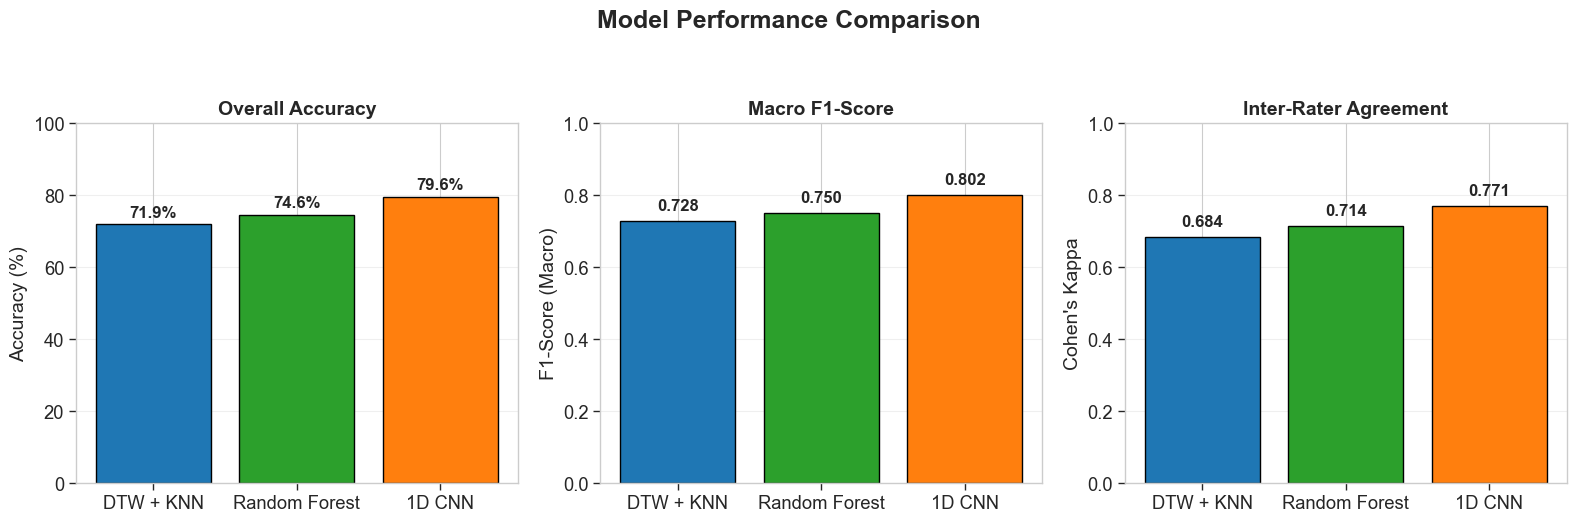

In [62]:
# Raw model names (match metrics_df columns)
raw_names = summary['model_names']  # ['dtw_knn', 'random_forest', 'cnn']

# Map raw names → pretty names (matching your MODEL_COLORS keys)
name_map = {
    'dtw_knn': 'DTW + KNN',
    'random_forest': 'Random Forest',
    'cnn': '1D CNN'
}

# Pretty names for plotting
pretty_names = [name_map[m] for m in raw_names]

# Extract metrics
acc = metrics_df.loc["Accuracy (%)", raw_names].values
f1  = metrics_df.loc["F1-Score (macro)", raw_names].values
precision = metrics_df.loc["Precision (macro)", raw_names].values
recall = metrics_df.loc["Recall (macro)", raw_names].values
kappa = metrics_df.loc["Cohen's Kappa", raw_names].values

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Model Performance Comparison', fontsize=18, fontweight='bold', y=1.05)

# ----- Accuracy -----
ax = axes[0]
bars = ax.bar(
    pretty_names,
    acc,
    color=[MODEL_COLORS[name_map[m]] for m in raw_names],
    edgecolor='black',
    linewidth=1
)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)
ax.set_title('Overall Accuracy', fontsize=14, fontweight='bold')

for bar, val in zip(bars, acc):
    ax.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# ----- F1-Score -----
ax = axes[1]
bars = ax.bar(pretty_names, f1,
              color=[MODEL_COLORS[name_map[m]] for m in raw_names],
              edgecolor='black', linewidth=1)
ax.set_ylabel('F1-Score (Macro)', fontsize=14)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)
ax.set_title('Macro F1-Score', fontsize=14, fontweight='bold')

for bar, val in zip(bars, f1):
    ax.text(bar.get_x() + bar.get_width()/2., val + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# ----- Cohen's Kappa -----
ax = axes[2]
bars = ax.bar(pretty_names, kappa,
              color=[MODEL_COLORS[name_map[m]] for m in raw_names],
              edgecolor='black', linewidth=1)
ax.set_ylabel("Cohen's Kappa", fontsize=14)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)
ax.set_title('Inter-Rater Agreement', fontsize=14, fontweight='bold')

for bar, val in zip(bars, kappa):
    ax.text(bar.get_x() + bar.get_width()/2., val + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
save_figure(fig, 'fig1_model_performance_bars', dpi=300, formats=['png', 'pdf'])
plt.show()

## Figure 2: Confusion Matrices (publication quality)

   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig2_confusion_matrices_absolute.png
   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig2_confusion_matrices_absolute.pdf


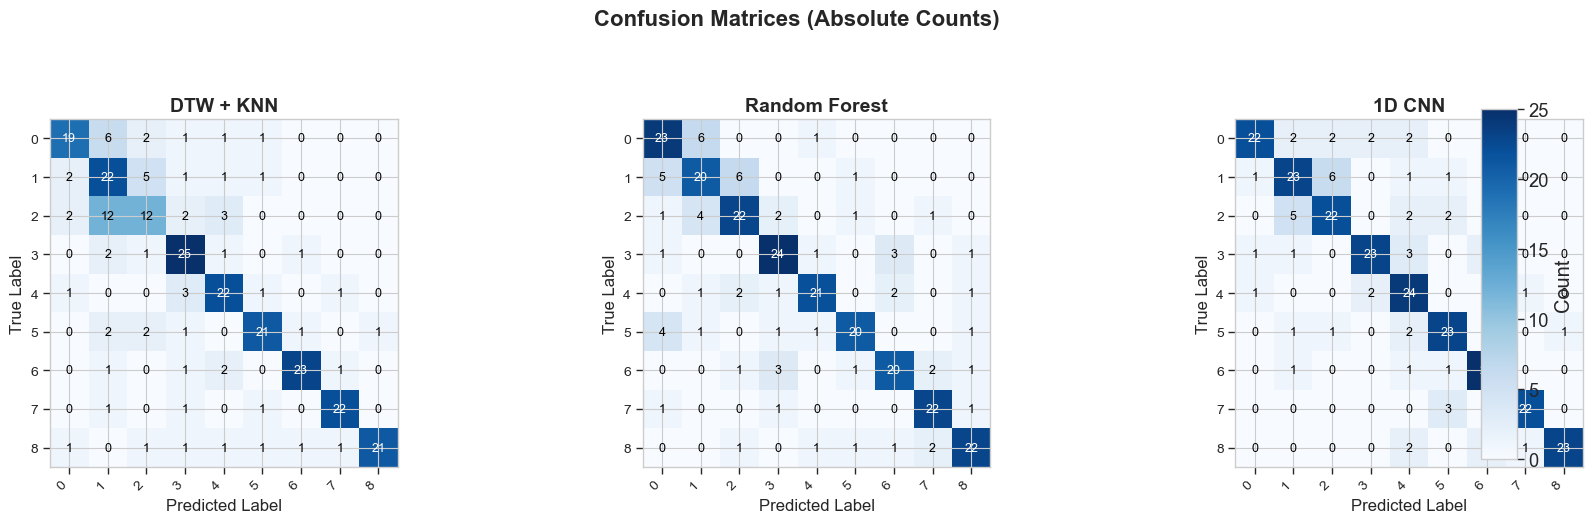

   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig3_confusion_matrices_normalized.png
   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig3_confusion_matrices_normalized.pdf


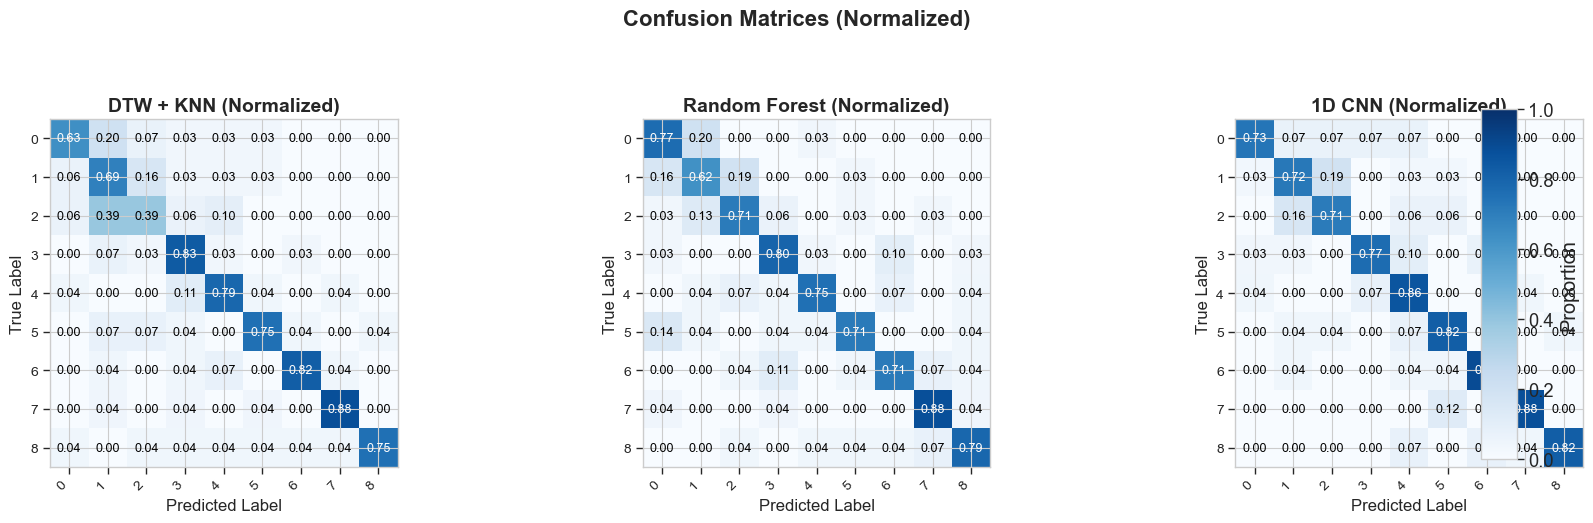

In [72]:
# Load confusion matrices from individual model result files
def load_confusion_matrices():
    """Load confusion matrices for each model using raw names from Notebook 7."""
    
    # Map raw names → pretty names → paths
    model_map = {
        'dtw_knn': {
            'pretty': 'DTW + KNN',
            'cm_path': '../results/04_dtw_knn_benchmark/confusion_matrix_counts.npy',
            'pkl_path': '../results/04_dtw_knn_benchmark/dtw_knn_results.pkl'
        },
        'random_forest': {
            'pretty': 'Random Forest',
            'cm_path': '../results/05_random_forest/confusion_matrix_counts.npy',
            'pkl_path': '../results/05_random_forest/random_forest_results.pkl'
        },
        'cnn': {
            'pretty': '1D CNN',
            'cm_path': '../results/06_cnn_1d/confusion_matrix_counts.npy',
            'pkl_path': '../results/06_cnn_1d/cnn_results.pkl'
        }
    }

    confusion_matrices = {}

    for raw_name in model_names:
        info = model_map[raw_name]
        pretty = info['pretty']
        cm_path = info['cm_path']
        pkl_path = info['pkl_path']

        # Always initialize cm
        cm = None

        # Try loading .npy first
        if os.path.exists(cm_path):
            cm = np.load(cm_path)
        else:
            # Fallback: load from pickle
            with open(pkl_path, 'rb') as f:
                data = pickle.load(f)
            y_pred = data['predictions']
            y_true = data['true_labels']
            cm = confusion_matrix(y_true, y_pred)

        confusion_matrices[pretty] = cm

    return confusion_matrices

confusion_matrices = load_confusion_matrices()

# Function to plot a beautiful confusion matrix
def plot_confusion_matrix_pub(cm, classes, ax, title, cmap=plt.cm.Blues, normalize=False):
    """Plot confusion matrix with improved aesthetics."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        vmax = 1.0
    else:
        fmt = 'd'
        vmax = cm.max()
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=vmax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
    # Show all ticks and label them
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=9)
    return im

# Create figure
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(6*len(confusion_matrices), 5))
if len(confusion_matrices) == 1:
    axes = [axes]

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    im = plot_confusion_matrix_pub(cm, classes, ax, f'{name}', normalize=False)

# Add colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Count')

fig.suptitle('Confusion Matrices (Absolute Counts)', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
save_figure(fig, 'fig2_confusion_matrices_absolute', dpi=300, formats=['png', 'pdf'])
plt.show()

# Normalized versions
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(6*len(confusion_matrices), 5))
if len(confusion_matrices) == 1:
    axes = [axes]

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    im = plot_confusion_matrix_pub(cm, classes, ax, f'{name} (Normalized)', normalize=True)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Proportion')

fig.suptitle('Confusion Matrices (Normalized)', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
save_figure(fig, 'fig3_confusion_matrices_normalized', dpi=300, formats=['png', 'pdf'])
plt.show()

## 3 Figure 3: Per-Class Accuracy (grouped bar chart)

   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig4_per_class_accuracy.png
   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig4_per_class_accuracy.pdf


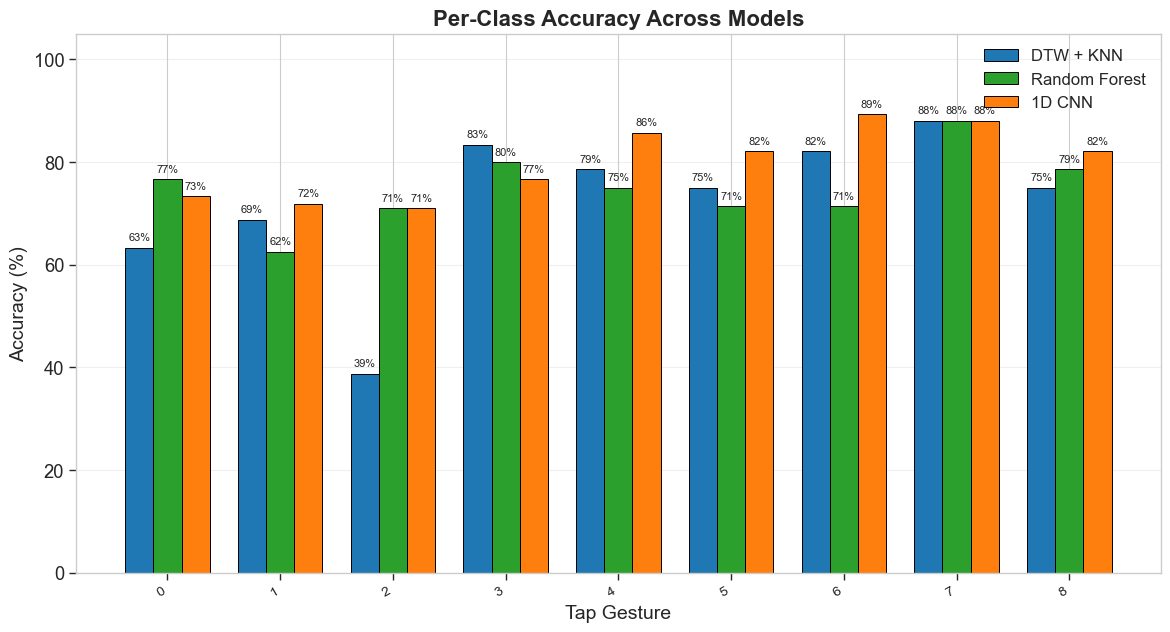

In [100]:
# Prepare data
per_class_pct = per_class_df  # already in %
x = np.arange(len(classes))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(figsize=(14, 7))

for raw, pretty in zip(model_names, pretty_names):
    offset = width * multiplier
    values = per_class_pct[raw].values  # correct column

    bars = ax.bar(
        x + offset,
        values,
        width,
        label=pretty,
        color=MODEL_COLORS[pretty],  # correct color
        edgecolor='black',
        linewidth=0.7
    )

    for bar, val in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            bar.get_height() + 1,
            f'{val:.0f}%',
            ha='center',
            va='bottom',
            fontsize=8
        )

    multiplier += 1

ax.set_xlabel('Tap Gesture', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_title('Per-Class Accuracy Across Models', fontsize=16, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(classes, rotation=30, ha='right', fontsize=10)
ax.legend(loc='upper right', fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 105)

save_figure(fig, 'fig4_per_class_accuracy', dpi=300, formats=['png', 'pdf'])
plt.show()

## Figure 4: Model Ranking and Statistical Significances (Heatmap of p-values)

   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig5_statistical_significance.png
   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig5_statistical_significance.pdf


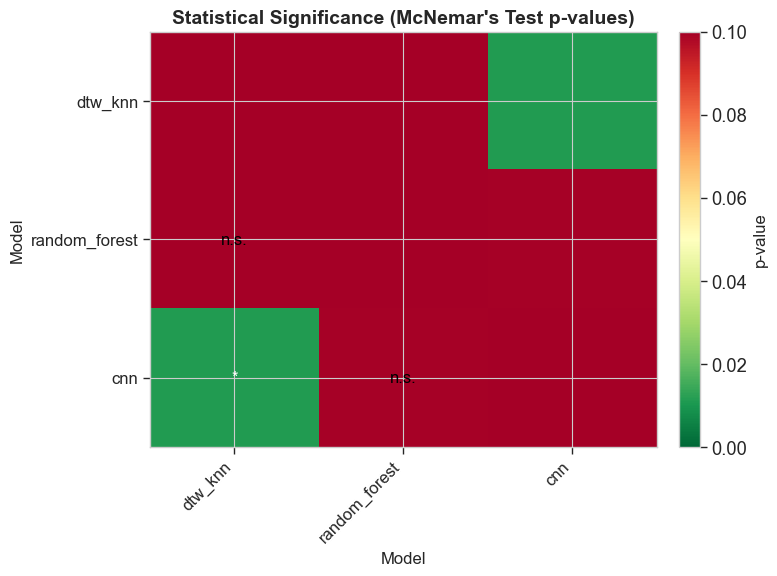

In [102]:
# Load McNemar results from Notebook 7
mcnemar_path = '../results/07_evaluation_framework/mcnemar_test_results.csv'
if os.path.exists(mcnemar_path):
    mcnemar_df = pd.read_csv(mcnemar_path)
    
    # Create a matrix of p-values
    n_models = len(model_names)
    pval_matrix = np.ones((n_models, n_models))
    signif_matrix = np.zeros((n_models, n_models), dtype=bool)
    
    for _, row in mcnemar_df.iterrows():
        i = model_names.index(row['Model1'])
        j = model_names.index(row['Model2'])
        p = row['p-value']
        pval_matrix[i, j] = p
        pval_matrix[j, i] = p
        signif_matrix[i, j] = row['Significant (p<0.05)']
        signif_matrix[j, i] = row['Significant (p<0.05)']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Mask the diagonal and upper triangle for a lower triangular heatmap
    mask = np.triu(np.ones_like(pval_matrix, dtype=bool), k=1)
    
    # Plot heatmap
    im = ax.imshow(pval_matrix, cmap='RdYlGn_r', vmin=0, vmax=0.1, 
                   aspect='auto', interpolation='nearest')
    
    # Add text annotations
    for i in range(n_models):
        for j in range(n_models):
            if i > j:  # lower triangle
                p = pval_matrix[i, j]
                text = f'{p:.3f}'
                if p < 0.001:
                    text = '***'
                elif p < 0.01:
                    text = '**'
                elif p < 0.05:
                    text = '*'
                else:
                    text = 'n.s.'
                ax.text(j, i, text, ha='center', va='center', fontsize=12,
                        color='white' if p < 0.05 else 'black')
    
    # Set ticks
    ax.set_xticks(np.arange(n_models))
    ax.set_yticks(np.arange(n_models))
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels(model_names, fontsize=12)
    
    ax.set_title('Statistical Significance (McNemar\'s Test p-values)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('p-value', fontsize=12)
    
    plt.tight_layout()
    save_figure(fig, 'fig5_statistical_significance', dpi=300, formats=['png', 'pdf'])
    plt.show()
else:
    print("⚠️ McNemar results not found. Skipping Figure 5.")

## Figure 5: Radar Chart of Per-Class Accuracy

   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig6_radar_chart.png
   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig6_radar_chart.pdf


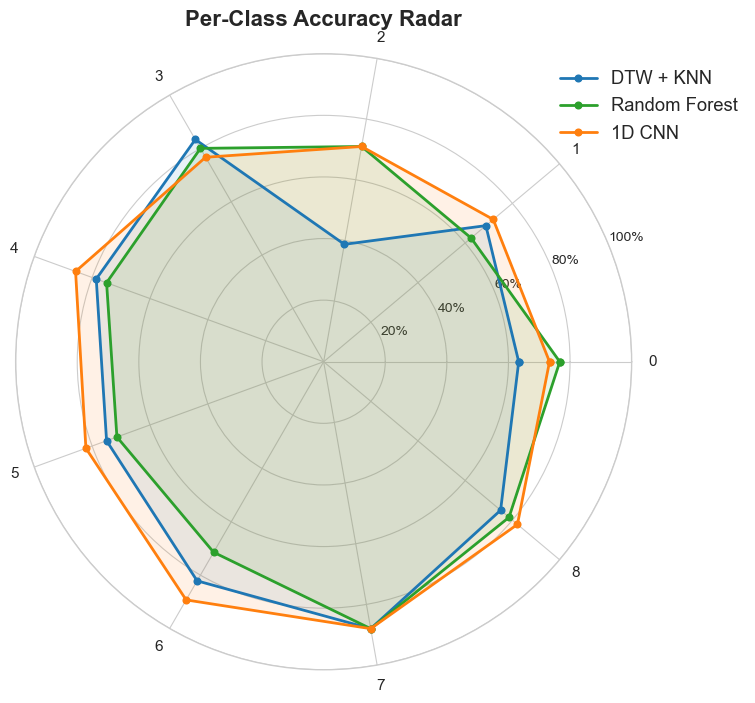

In [110]:
def radar_chart(df, model_names, classes, figsize=(8, 8)):
    """Create a radar chart comparing per-class accuracy."""
    from math import pi
    
    # Raw → Pretty name mapping
    name_map = {
        'dtw_knn': 'DTW + KNN',
        'random_forest': 'Random Forest',
        'cnn': '1D CNN'
    }
    
    # Number of variables
    N = len(classes)
    
    # Angles for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # close the loop
    
    # Initialize figure
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': 'polar'})
    
    # Add each model's data
    for model in model_names:
        pretty = name_map[model]  # FIXED: inside loop
        
        values = df[model].values / 100  # convert % to proportion
        values = np.append(values, values[0])  # close the loop
        
        # Line
        ax.plot(
            angles, values, 'o-', linewidth=2,
            label=pretty,
            color=MODEL_COLORS[pretty]  # FIXED
        )
        
        # Fill
        ax.fill(
            angles, values,
            alpha=0.1,
            color=MODEL_COLORS[pretty]  # FIXED
        )
    
    # Set category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes, fontsize=11)
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=10)
    ax.grid(True)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    
    ax.set_title('Per-Class Accuracy Radar', fontsize=16, fontweight='bold', pad=20)
    return fig
fig = radar_chart(per_class_pct, model_names, classes)
save_figure(fig, 'fig6_radar_chart', dpi=300, formats=['png', 'pdf'])
plt.show()

## Table 1: Summary Table in LaTeX format

In [114]:
def generate_latex_table(metrics_df, caption="Model Performance Comparison", label="tab:model_comparison"):
    """Generate a LaTeX-ready table of performance metrics."""
    
    # Transpose so rows = models, columns = metrics
    table_df = metrics_df.T.copy()
    
    # Ensure correct column order
    cols = ['Accuracy (%)', 'Precision (macro)', 'Recall (macro)', 
            'F1-Score (macro)', "Cohen's Kappa"]
    table_df = table_df[cols]
    
    # Round values
    table_df = table_df.round({
        'Accuracy (%)': 1,
        'Precision (macro)': 3,
        'Recall (macro)': 3,
        'F1-Score (macro)': 3,
        "Cohen's Kappa": 3
    })
    
    latex_str = table_df.to_latex(
        caption=caption,
        label=label,
        column_format='lccccc',
        escape=False
    )
    
    # Save to file
    with open(os.path.join(FIGURES_DIR, 'table1_performance.tex'), 'w') as f:
        f.write(latex_str)
    
    print("✅ LaTeX table saved to:", os.path.join(FIGURES_DIR, 'table1_performance.tex'))
    return latex_str

latex_table = generate_latex_table(metrics_df)
print("\n📋 LaTeX Table Preview:\n")
print(latex_table)

✅ LaTeX table saved to: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\table1_performance.tex

📋 LaTeX Table Preview:

\begin{table}
\caption{Model Performance Comparison}
\label{tab:model_comparison}
\begin{tabular}{lccccc}
\toprule
 & Accuracy (%) & Precision (macro) & Recall (macro) & F1-Score (macro) & Cohen's Kappa \\
\midrule
dtw_knn & 71.900000 & 0.743000 & 0.725000 & 0.728000 & 0.684000 \\
random_forest & 74.600000 & 0.755000 & 0.750000 & 0.750000 & 0.714000 \\
cnn & 79.600000 & 0.810000 & 0.800000 & 0.802000 & 0.771000 \\
\bottomrule
\end{tabular}
\end{table}



## Figure 6: Feature Importance from Random Forest

   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig7_feature_importance_rf.png
   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig7_feature_importance_rf.pdf


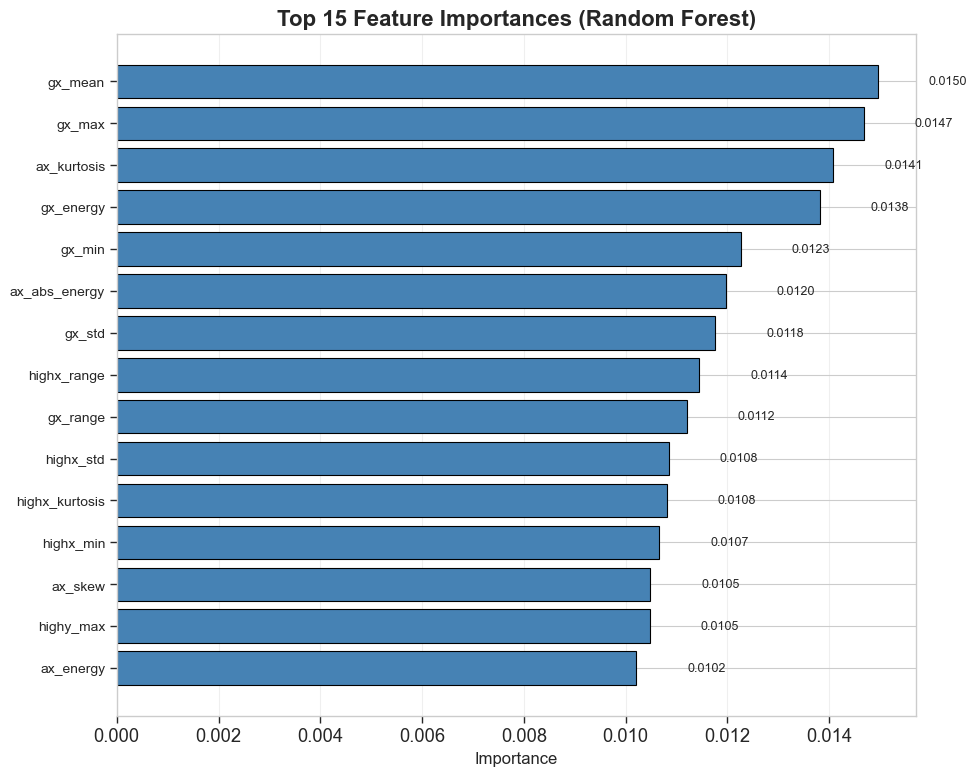

In [116]:
def load_rf_feature_importance():
    """Load feature importances from Random Forest results."""
    path = '../results/05_random_forest/feature_importances.csv'
    if os.path.exists(path):
        return pd.read_csv(path)
    else:
        return None

fi_df = load_rf_feature_importance()
if fi_df is not None:
    # Plot top 15 features
    top_n = 15
    top_features = fi_df.head(top_n)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.barh(np.arange(top_n), top_features['importance'].values, 
                   color='steelblue', edgecolor='black')
    ax.set_yticks(np.arange(top_n))
    ax.set_yticklabels(top_features['feature'].values, fontsize=10)
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Top {top_n} Feature Importances (Random Forest)', fontsize=16, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, top_features['importance'].values):
        ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    save_figure(fig, 'fig7_feature_importance_rf', dpi=300, formats=['png', 'pdf'])
    plt.show()

## Figure 7: CNN Training History

   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig8_cnn_training_history.png
   Saved: C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures\fig8_cnn_training_history.pdf


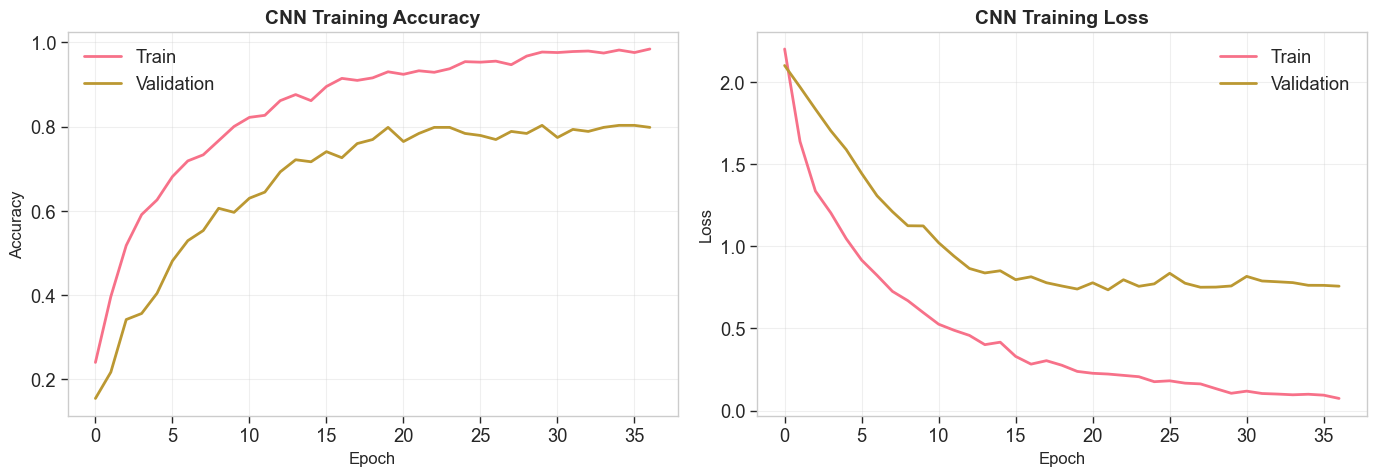

In [118]:
def load_cnn_history():
    """Load CNN training history."""
    path = '../results/06_cnn_1d/training_history.pkl'
    if os.path.exists(path):
        with open(path, 'rb') as f:
            history = pickle.load(f)
        return history
    return None

history = load_cnn_history()
if history is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('CNN Training Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Loss
    axes[1].plot(history['loss'], label='Train', linewidth=2)
    axes[1].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('CNN Training Loss', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    save_figure(fig, 'fig8_cnn_training_history', dpi=300, formats=['png', 'pdf'])
    plt.show()

## Export all Figures to a Single Archive

In [ ]:
import shutil
from datetime import datetime

# Create a timestamped zip archive of all final figures
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
archive_name = f'BackTapBench_Figures_{timestamp}'
archive_path = os.path.join(RESULTS_DIR, archive_name)
shutil.make_archive(archive_path, 'zip', FIGURES_DIR)
print(f"📦 All figures archived to: {archive_path}.zip")

## Final Summary & Next Steps

In [122]:
print("\n" + "="*70)
print("🎯 PUBLICATION-READY VISUALIZATION COMPLETE")
print("="*70)

# Identify best model
best_model = metrics_df.loc["Accuracy (%)"].idxmax()
best_acc = metrics_df.loc["Accuracy (%)", best_model]
best_f1 = metrics_df.loc["F1-Score (macro)", best_model]

print(f"\n📊 Best Model: **{best_model}**")
print(f"   Accuracy: {best_acc:.1f}%")
print(f"   F1-Score: {best_f1:.3f}")

print(f"\n📁 All outputs saved to:")
print(f"   {RESULTS_DIR}/")
print(f"   {FIGURES_DIR}/")
print(f"   📦 Archive: {archive_path}.zip")

print("\n✅ Generated visualizations:")
for fmt in ['png', 'pdf']:
    print(f"   - fig1_model_performance_bars.{fmt}")
    print(f"   - fig2_confusion_matrices_absolute.{fmt}")
    print(f"   - fig3_confusion_matrices_normalized.{fmt}")
    print(f"   - fig4_per_class_accuracy.{fmt}")
    print(f"   - fig5_statistical_significance.{fmt} (if available)")
    print(f"   - fig6_radar_chart.{fmt}")
    print(f"   - fig7_feature_importance_rf.{fmt} (if available)")
    print(f"   - fig8_cnn_training_history.{fmt} (if available)")

print("\n📋 LaTeX table:")
print("   - table1_performance.tex")

print("\n" + "="*70)
print("✅ BackTapBench Benchmarking Complete!")
print("="*70)


🎯 PUBLICATION-READY VISUALIZATION COMPLETE

📊 Best Model: **cnn**
   Accuracy: 79.6%
   F1-Score: 0.802

📁 All outputs saved to:
   C:\Users\jumia\Downloads\BackTap\results\08_results_visualization/
   C:\Users\jumia\Downloads\BackTap\results\08_results_visualization\final_figures/


NameError: name 'archive_path' is not defined